In [30]:
import json
import matplotlib.pyplot as plt
import numpy as np

for backends in [['CPU'],['GPU']]:
    if backends == ['GPU']:
        solvers = ['cufinufft']
        data = []
        lmaxs = np.array([2**n-1 for n in np.arange(9,13)])
        for lmax in lmaxs:
            with open('/mnt/home/sbelkner/git/pySHT/test/benchmark/timings/{backends}_{solver}_{lmax}'.format(backends=backends[0], solver=solvers[0], lmax=lmax), "r") as file:
                data.append(json.load(file))
        data[0].pop("get pointing - ctyping")
        data[0].pop("get pointing - data grab")
        keys_GPU = data[0].keys()
        
        data_across_l = {}
        for d in data:
            for keyi, key in enumerate(keys_GPU):
                if key in data_across_l:
                    data_across_l[key].append(d[key])
                else:
                    data_across_l[key] = [d[key]]
        resGPU = np.array([v for k, v in data_across_l.items()])
                    
    else:
        solvers = ['duccnufft']
        data = []
        lmaxs = np.array([2**n-1 for n in np.arange(9,13)])
        for lmax in lmaxs:
            with open('/mnt/home/sbelkner/git/pySHT/test/benchmark/timings/{backends}_{solver}_{lmax}'.format(backends=backends[0], solver=solvers[0], lmax=lmax), "r") as file:
                data.append(json.load(file))
                
        keys_CPU = data[0].keys()
        ## collect data
        data_across_l = {}
        for d in data:
            for keyi, key in enumerate(keys_CPU):
                if key in data_across_l:
                    data_across_l[key].append(d[key])
                else:   
                    data_across_l[key] = [d[key]]
        resCPU = np.array([v for k, v in data_across_l.items()])

Text(0.5, 1.0, 'GPU')

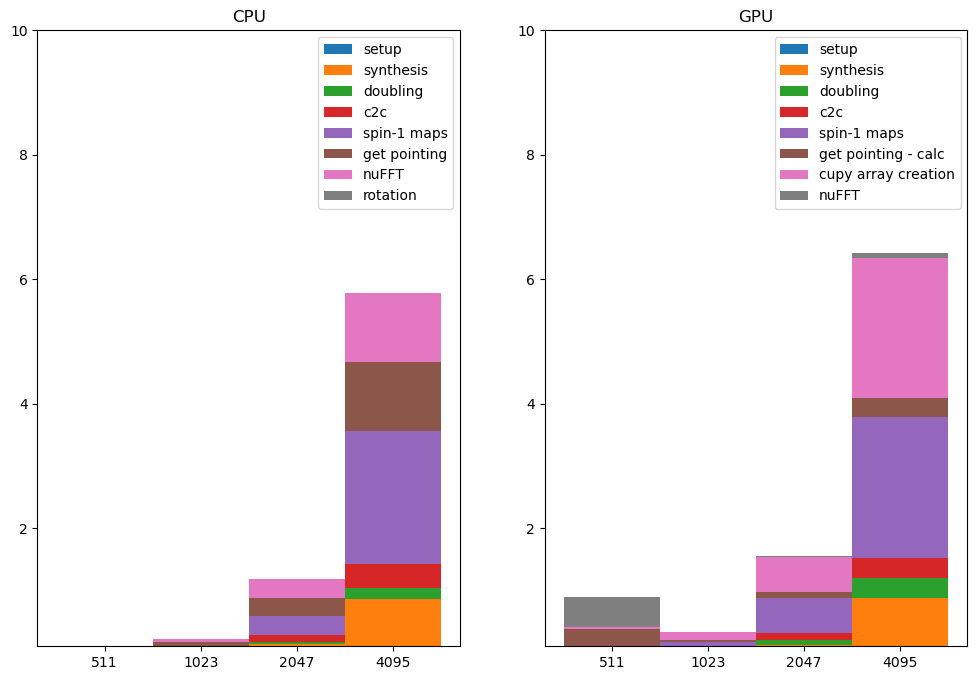

In [31]:
fig, ax = plt.subplots(1,2,figsize=(12,8), sharey=False)
bottom = np.zeros(shape=(len(lmaxs)))
# lmaxs.astype(str)
for rowi, row in enumerate(resCPU): #[:-1,:]
    ax[0].bar(lmaxs.astype(str), row, 1, align='center', bottom=bottom, label=list(keys_CPU)[rowi])
    bottom+=row
ax[0].legend()
ax[0].set_title("CPU")
ax[0].set_ylim(0.1, 10)

bottom = 0
for rowi, row in enumerate(resGPU): #[:-1,:]
    ax[1].bar(lmaxs.astype(str), row, 1, align='center', bottom=bottom, label=list(keys_GPU)[rowi])
    bottom+=row
ax[1].legend()
ax[1].set_title("GPU")
ax[1].set_ylim(0.1, 10)

ax[1].set_title("GPU")
# ax[0].set_yscale('log')
# ax[1].set_yscale('log')

In [32]:
resCPU[5], resGPU[7]

(array([0.01644158, 0.06579828, 0.28715968, 1.11587238]),
 array([0.47341251, 0.00587106, 0.02245164, 0.09069753]))

Text(0.5, 1.0, 'GPU, cufinufft')

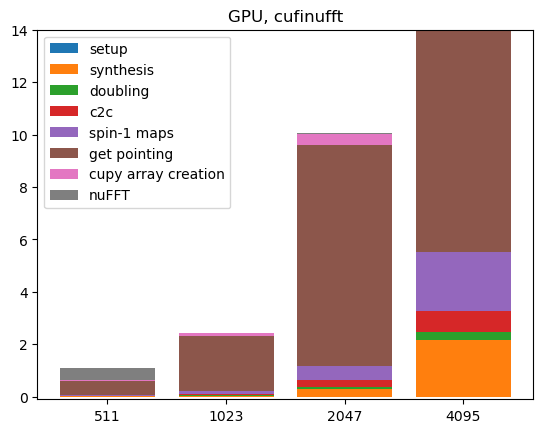

In [14]:
bottom = 0
for rowi, row in enumerate(resGPU):
    plt.bar(lmaxs.astype(str), row, label=list(keys_GPU)[rowi], bottom=bottom)
    bottom+=row
plt.ylim(-0.1,14)
plt.legend()
plt.title("{}, {}".format("GPU", solvers[0]))
# plt.yscale('log')
# plt.plot(np.sum(resGPU,axis=0))

[0.00678706 0.04159284 0.26842809 1.95340896]
[0.00399113 0.01899076 0.07885933 0.31067562]
[0.01210046 0.05250621 0.17352605 1.07319474]
[0.07713652 0.22913742 1.03034139 4.94857383]
[0.07327223 0.28234076 1.05452466 4.64766717]
[0.00098872 0.00505614 0.03063631 0.12074876]


(-0.1, 14.0)

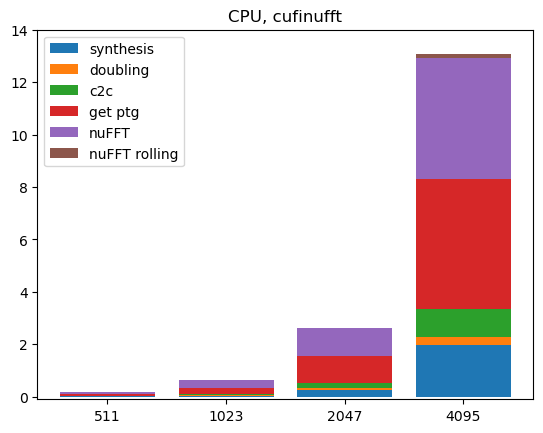

In [15]:
bottom = 0
for rowi, row in enumerate(resCPU): #[:-1,:]
    print(row)
    plt.bar(lmaxs.astype(str), row, label=list(keys_CPU)[rowi], bottom=bottom)
    bottom+=row
plt.legend()
plt.title("{}, {}".format("CPU", solvers[0]))
plt.ylim(-0.1,14)
# plt.yscale('log')
# plt.plot(np.sum(resCPU,axis=0))

In [103]:
for row in result_nparra:
    print(row)

[1.29497051e-02 2.28881836e-04 4.08887863e-04 2.05874443e-03
 9.66072083e-03 4.15675640e-02 2.71995544e-01 1.95598769e+00]
[6.74724579e-05 1.45673752e-04 1.16348267e-04 6.25133514e-04
 2.78091431e-03 1.90243721e-02 7.75604248e-02 3.17705870e-01]
[1.86443329e-04 2.95162201e-04 9.86099243e-04 1.06279850e-02
 1.19304657e-02 5.46987057e-02 1.72783613e-01 1.07687783e+00]
[0.0287199  0.02040863 0.02634001 0.05550146 0.12050819 0.51339126
 2.35521603 9.61247635]
[8.29696655e-05 7.77244568e-05 1.38044357e-04 3.10659409e-04
 1.14321709e-03 4.81247902e-03 3.10497284e-02 1.25223637e-01]
